# 보스턴 주택 가격 예측
- 사이킷런의 linear_models 모듈은 매우 다양한 종류의 선형 기반 회귀를 클래스로 구현해 제공한다.
- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
### LinearRegression 클래스
- 규제가 적용되지 않은 일반 선형 회귀를 사이킷런에서 구현한 클래스
- 예측값과 실제 값의 RSS(Residual Sum of Squares)를 최소화해 OLS(Ordinary Least Squares) 추정 방식으로 구현한 클래스
- Ordinary Least Squares 기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받는다. 피처간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 매우 민감해진다. 일반적으로 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용한다.
- fit() 메서드로 X, y 배열을 입력 받으면 회귀 계수(Coefficients)인 W를 coef_ 속성에 저장한다.

#### 입력 파라미터와 속성

- fit_intercept : intercept(절편) 값을 계산할 것인지 말지를 지정한다. False로 지정하면 intercept가 0으로 지정된다.
- normalize : 회귀를 수행하기 전에 입력 데이터 세트를 정규화한다. fit_intercept가 False인 경우 무시된다.
- coef_ : fit() 메서드를 수행했을 때 회귀 계수가 배열 형태로 저장하는 속성. Shape는 (target 값 개수, 피처 개수)
- intercept_ : intercept 값

### 회귀 평가 지표
- 회귀의 평가를 위한 지표는 실제 값과 회귀 예측값의 차이 값을 기반으로 한 지표가 중심이다.
- 실제값과 예측값의 차이를 그냥 더하면 +와 -가 섞여서 오류가 상쇄되기 때문에 정확한 지표가 될 수 없다.
- 따라서 오류의 절댓값 평균이나 제곱, 또는 제곱한 뒤 다시 루트를 씌운 평균값을 구한다.
    - MAE(Mean Absolute Error) : 실제 값과 예측값의 차이를 절댓값으로 변환해 평균한 것
    - MSE(Mean Squared Error) : 실제 값과 예측값의 차이를 제곱해 평균한 것
    - R^2 : 분산 기반으로 예측 성능을 평가한다. 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높다.

### LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이터 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격. 이를 PRICE 칼럼으로 DataFrame에 추가
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기 :', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- CRIM : 지역별 범죄 발생률
- ZN : 25,000평방피트를 초과하는 거주 지역의 비율
- INDUS : 비상업 지역 넓이 비율
- CHAS : 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX : 일산화질소 농도
- RM : 거주할 수 있는 방 개수
- AGE : 1940년 이전에 건축된 소유 주택의 비율
- DIS : 5개 주요 고용센터까지의 가중 거리
- RAD : 고속도로 접근 용시도
- TAX : 10,000달러당 재산세율
- PTRATIO : 지역이 교사와 학생 수 비율
- B : 지역의 흑인 거주 비율
- LSTAT : 하위 계층의 비율
- MEDV : 본인 소유의 주택 가격(중앙값)

In [2]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


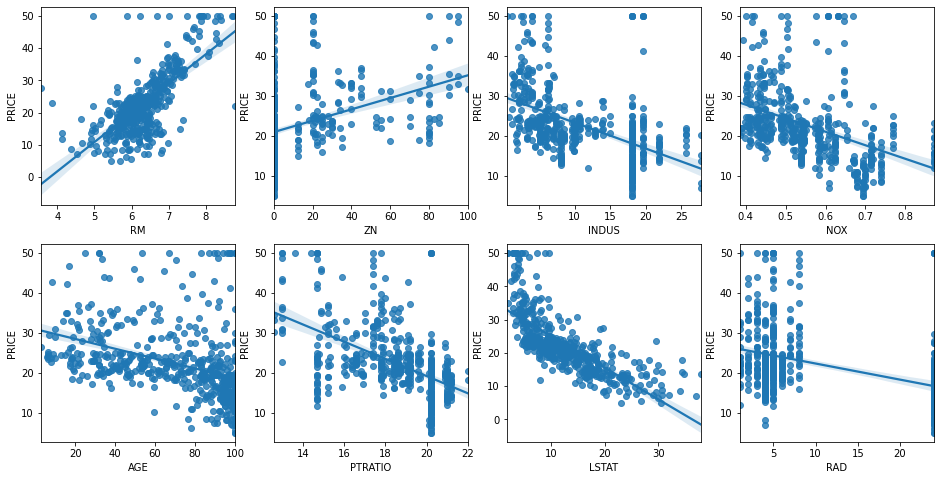

In [3]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4*2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

- RM과 LSTAT의 PRICE 영향도가 가장 두드러지게 나타난다.
- RM(방 개수)은 양 방향의 선형성(Positive Linearity)이 가장 크다. 즉, 방의 크기가 클수록 가격이 증가한다.
- LSTAT(하위 계층의 비율)은 음 방향의 선형성(Negative Linearity)이 가장 크다. 즉, 하위 계층의 비율이 적을 수록 가격이 증가한다.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f},'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159,
Variance score : 0.757


In [5]:
print('절편 값:', lr.intercept_)
print('회귀 계수 값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164336
회귀 계수 값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [6]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

- RM이 양의 값으로 회귀 계수가 가장 크고, NOX 피처의 회귀 계수 - 값이 너무 크다.

In [7]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE를 구함
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print('5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print('5 folds 의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print('5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds 의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
5 folds 의 평균 RMSE : 5.829


In [8]:
()

()